In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Multi-Modal Data Training with Keras

In this notebook, we demonstrate the use of pre-trained embedding with a Keras wide and deep model.

In [ ]:
!pip install tensorflow-gpu==2.5.0

In [3]:
# External dependencies
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

    

1 Physical GPUs, 1 Logical GPUs


In [4]:
INPUT_DATA_DIR = "./data"

In [5]:
movies = pd.read_csv(os.path.join(INPUT_DATA_DIR, 'ml-25m/movies.csv'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
#genres_map, movies['genres_type'] = pd.factorize(movies['genres'])

In [7]:
ratings = pd.read_csv(os.path.join(INPUT_DATA_DIR, "ml-25m", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [8]:
ratings['label'] = 0
ratings.loc[ratings['rating']>3,'label'] = 1
ratings.loc[ratings['rating']<=3,'label'] = 0
ratings.pop('rating')

ratings = ratings.drop('timestamp', axis=1)
ratings = ratings.merge(movies, on='movieId', how='left')


In [9]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

print(train.shape)
train.head()

(20000076, 5)


,userId,movieId,label,title,genres
19120594,124027,56587,1,"Bucket List, The (2007)",Comedy|Drama
15253127,98809,2641,0,Superman II (1980),Action|Sci-Fi
12584278,81377,122886,1,Star Wars: Episode VII - The Force Awakens (2015),Action|Adventure|Fantasy|Sci-Fi|IMAX
18034326,116853,78499,1,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
18073299,117118,1302,0,Field of Dreams (1989),Children|Drama|Fantasy


In [10]:
BATCH_SIZE = 32768

LABEL = 'label'
train_target = train.pop(LABEL)
train_dataset = tf.data.Dataset.from_tensor_slices((train.to_dict('list'), train_target.values)).cache().batch(BATCH_SIZE)


In [11]:
test_target = test.pop(LABEL)
test_dataset = tf.data.Dataset.from_tensor_slices((test.to_dict('list'), test_target.values)).cache().batch(BATCH_SIZE)


In [12]:
train_dataset.take(10)

<TakeDataset shapes: ({userId: (None,), movieId: (None,), title: (None,), genres: (None,)}, (None,)), types: ({userId: tf.int32, movieId: tf.int32, title: tf.string, genres: tf.string}, tf.int64)>

# Create Keras model

In [13]:
TARGET_FEATURE_NAME = "rating"

TARGET_FEATURE_LABELS = [0, 1]

NUMERIC_FEATURE_NAMES = []

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "movieId": sorted(list(train["movieId"].unique())),
    "userId": sorted(list(train["userId"].unique())),
    "genres": sorted(list(train["genres"].unique())),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

NUM_CLASSES = len(TARGET_FEATURE_LABELS)


In [14]:
inputs = {}

inputs["movieId"] = layers.Input(
                name="movieId", shape=(), dtype=tf.int32
            )
inputs["userId"] = layers.Input(
                name="userId", shape=(), dtype=tf.int32
            )
inputs["genres"] = layers.Input(
                name="genres", shape=(), dtype=tf.string
            )

In [15]:
# Read movie poster & synopsys embedding 
import pandas as pd

feature_df = pd.read_parquet('feature_df.parquet')
print(feature_df.shape)
feature_df.head()


(62423, 3073)


,movieId,poster_feature_0,poster_feature_1,poster_feature_2,poster_feature_3,poster_feature_4,poster_feature_5,poster_feature_6,poster_feature_7,poster_feature_8,...,text_feature_1014,text_feature_1015,text_feature_1016,text_feature_1017,text_feature_1018,text_feature_1019,text_feature_1020,text_feature_1021,text_feature_1022,text_feature_1023
0,1.0,0.000000,0.088281,0.036760,0.000000,0.006470,0.000000,0.023553,0.000163,0.238797,...,0.291230,-0.197272,0.024294,1.307049,-0.789571,0.084938,-0.187339,0.061683,0.183281,-0.356245
1,2.0,0.000000,0.000000,0.000000,0.289105,0.134672,0.691380,0.045417,0.000000,0.051422,...,0.203168,-0.617449,0.443821,1.501953,-0.736949,0.180542,-0.313696,0.274087,0.153105,-0.218745
2,3.0,0.000000,0.187553,0.000000,0.904370,0.069441,0.026665,0.817211,0.000000,0.125072,...,0.173140,-0.209240,0.451933,1.491917,-0.743956,-0.069061,-0.900011,0.583347,0.192817,0.224088
3,4.0,0.182279,0.014646,0.004135,0.197796,0.077938,0.000000,0.215127,0.021160,0.023108,...,-0.394012,0.679462,1.225475,1.196255,-0.169627,-0.008575,-0.172138,0.114755,-0.127861,-0.003679
4,5.0,0.000000,0.082123,0.447287,0.002375,0.135956,0.000000,0.989514,0.808180,0.317510,...,-0.176658,-0.078992,0.726118,1.017430,-0.249834,0.183357,-0.071451,0.644567,0.090399,-1.147284


In [16]:
feature_df.movieId = feature_df.movieId.astype(int)

In [17]:
feature_df.set_index('movieId', inplace=True)

In [18]:
feature_df.loc[1]

poster_feature_0     0.000000
poster_feature_1     0.088281
poster_feature_2     0.036760
poster_feature_3     0.000000
poster_feature_4     0.006470
                       ...   
text_feature_1019    0.084938
text_feature_1020   -0.187339
text_feature_1021    0.061683
text_feature_1022    0.183281
text_feature_1023   -0.356245
Name: 1, Length: 3072, dtype: float64

In [19]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup, IntegerLookup
movie_lookup = IntegerLookup(
    vocabulary=CATEGORICAL_FEATURES_WITH_VOCABULARY['movieId'],
    num_oov_indices=1,
    output_mode="int",
)

In [20]:
vocab = movie_lookup.get_vocabulary()
movie_index = dict(zip(vocab, range(len(vocab))))

In [21]:
len(vocab)

56587

In [22]:
num_tokens = len(vocab)
embedding_dim = 2048+1024
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for movieId, i in movie_index.items():
    if movieId in feature_df.index: 
        embedding_vector = feature_df.loc[movieId]
        # embedding found
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Found features for %d movies (%d misses)" % (hits, misses))


Found features for 56585 movies (2 misses)


In [23]:
from tensorflow.keras.layers import Embedding

feature_embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [27]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup, IntegerLookup

def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            if use_embedding: # feature for deep part
                if feature_name in ["movieId", "userId"]:
                    print(feature_name, vocabulary[:10])
                    lookup = IntegerLookup(
                        vocabulary=vocabulary,
                        num_oov_indices=1,
                        output_mode="int",
                    )
                else:
                    print(feature_name, vocabulary[:10])
                    lookup = StringLookup(
                        vocabulary = train[feature_name].unique(),
                        num_oov_indices=1,
                        output_mode="int",
                    )
                    
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                vocabulary = lookup.get_vocabulary()
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                
                #adding pretrained movie feature embedding
                if feature_name in ["movieId"]:
                    pretrained_feature = feature_embedding_layer(encoded_feature)

                    # Convert the index values to embedding representations and add pretrained movie feature embedding
                    encoded_feature = layers.concatenate([embedding(encoded_feature), pretrained_feature])
                else:
                    # Convert the index values to embedding representations.
                    encoded_feature = embedding(encoded_feature)
                    
            else: # feature for wide part
                if feature_name in ["movieId", "userId"]:
                    print(feature_name, vocabulary[:10])
                    lookup = IntegerLookup(
                        vocabulary=[x[0] for x in Counter(train[feature_name]).most_common(10000)],
                        num_oov_indices=1000,
                        output_mode="binary",
                    )
                else:
                    print(feature_name, vocabulary[:10])
                    lookup = StringLookup(
                        vocabulary = [x[0] for x in Counter(train[feature_name]).most_common(10000)],
                        num_oov_indices=1000,
                        output_mode="binary",
                    )
                    
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

movieId [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
userId [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
genres ['(no genres listed)', 'Action', 'Action|Adventure', 'Action|Adventure|Animation', 'Action|Adventure|Animation|Children', 'Action|Adventure|Animation|Children|Comedy', 'Action|Adventure|Animation|Children|Comedy|Fantasy', 'Action|Adventure|Animation|Children|Comedy|IMAX', 'Action|Adventure|Animation|Children|Comedy|Romance', 'Action|Adventure|Animation|Children|Comedy|Sci-Fi']
movieId [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
userId [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
genres ['(no genres listed)', 'Action', 'Action|Adventure', 'Action|Adventure|Animation', 'Action|Adventure|Animation|Children', 'Action|Adventure|Animation|Children|Comedy', 'Action|Adventure|Animation|Children|Comedy|Fantasy', 'Action|Adventure|Animation|Children|Comedy|IMAX', 'Action|Adventure|Animation|Children|Comedy|Romance', 'Action|Adventure|Animation|Children|Comedy|Sci-Fi']


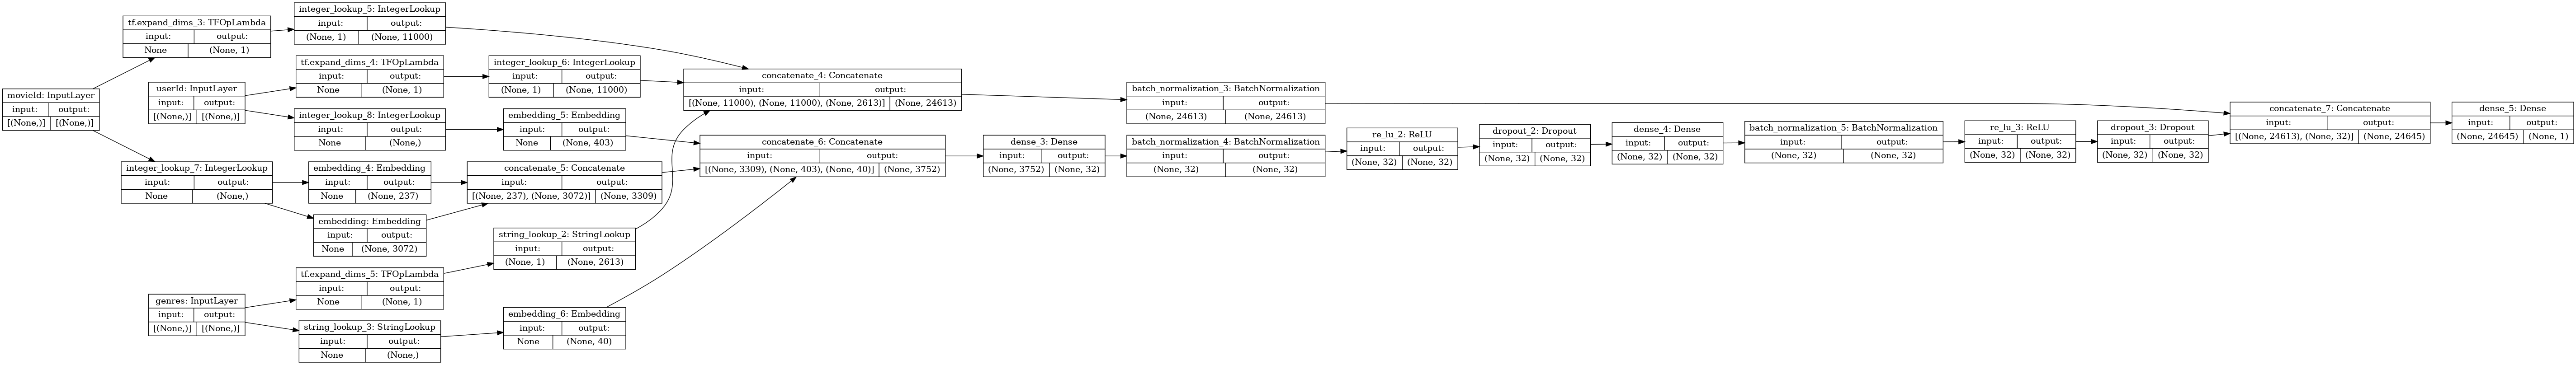

In [28]:
learning_rate = 0.001
dropout_rate = 0.1
num_epochs = 50

hidden_units = [32, 32]

def create_wide_and_deep_model(inputs):

    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=1, activation="sigmoid")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model(inputs)
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [ ]:
metrics = [
    keras.metrics.AUC(name="AUC"),
]

model = wide_and_deep_model
model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

print("Start training the model...")
history = model.fit(train_dataset, 
                    epochs=10,
                    validation_data = test_dataset
                   )
print("Model training finished")

Start training the model...
Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


 35/611 [>.............................] - ETA: 6:09 - loss: 0.6205 - AUC: 0.6882